In [1]:
import warnings
warnings.filterwarnings("ignore")

from gensim.models import ldamodel

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import entropy
import ruptures as rpt

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.tight_layout()
plt.style.use('seaborn-v0_8-darkgrid')

plt.rcParams['figure.figsize'] = (10, 5)

from utils import dataset, load_bow

<Figure size 640x480 with 0 Axes>

In [2]:
col = [
    'Publication Type', \
    'Venue', \
    'Author Full Names', \
    'Article Title', \
    'Abstract', \
    'Publication Date', \
    'Publication Year']

venues = dataset()[col]
venues = venues.dropna(subset=['Abstract'])
venues['Abstract Lemmatized'] = load_bow('25_venues')
venues = venues.dropna(subset=['Publication Date'])
venues['Date'] = (venues['Publication Date']+'-'+venues['Publication Year']).apply(lambda x: datetime.strptime(x, '%b-%Y'))
venues = venues.sort_values(by='Date')
venues.index = range(len(venues))

In [3]:
model_name = '60_asymmetric_auto_0.5_0.0075'
model = ldamodel.LdaModel.load(f'models/lda_models/{model_name}')

In [4]:
def get_topics(bow):
    return model.get_document_topics(model.id2word.doc2bow(bow), minimum_probability=0)
venues['LDA Distribution'] = venues['Abstract Lemmatized'].apply(lambda x: get_topics(x))

In [54]:
df = venues[['Date', 'Venue', 'LDA Distribution']]
date_dict = {pd.Timestamp(i): (df['Date'][df['Date'] == i].index[0], df['Date'][df['Date'] == i].index[-1]) for i in df['Date'].unique()}

In [6]:
topic_df = pd.read_csv('models/topics.csv')
topic_df

,Topics,Labels,Groups,Terms
0,0,Graph Theory and Network Structures,Networks,"0.134*""graph"" + 0.075*""structure"" + 0.066*""nod..."
1,1,Control Systems and Dynamic Systems,Systems & Control,"0.050*""control"" + 0.039*""system"" + 0.026*""time..."
2,2,Systems and Energy Management,Systems & Control,"0.043*""system"" + 0.019*""power"" + 0.014*""time"" ..."
3,3,Multi-level Feature Fusion and Deep Learning,DL,"0.024*""multi"" + 0.020*""level"" + 0.019*""feature..."
4,4,Probability Distribution and Estimation Algori...,Statistics,"0.030*""distribution"" + 0.020*""algorithm"" + 0.0..."
5,5,Evolutionary Algorithm and Optimization,Genetic,"0.065*""algorithm"" + 0.032*""optimization"" + 0.0..."
6,6,Urban Navigation and Localization,Navigation,"0.053*""location"" + 0.027*""trajectory"" + 0.023*..."
7,7,Object Recognition and Visual Saliency,CV,"0.162*""object"" + 0.069*""visual"" + 0.033*""image..."
8,8,Object Detection,CV,"0.201*""detection"" + 0.077*""detect"" + 0.031*""de..."
9,9,Cybersecurity & Network Communication,Cybersecurity,"0.050*""event"" + 0.037*""attack"" + 0.035*""servic..."


# TOPIC FREQUENCE TRENDS

In [56]:
for K in range(60):
    df[f'Topic {K}'] = df['LDA Distribution'].apply(lambda x: x[K][1] if K in [y[0] for y in x] else 0)

In [58]:
data = df.groupby('Date').sum()/df.groupby('Date').count()
data = data.drop(columns=['LDA Distribution', 'Venue'])
data_norm = data/data.iloc[0]

In [9]:
rolling_data = data.rolling(12).mean().dropna()
rolling_data_norm = rolling_data/rolling_data.iloc[0]

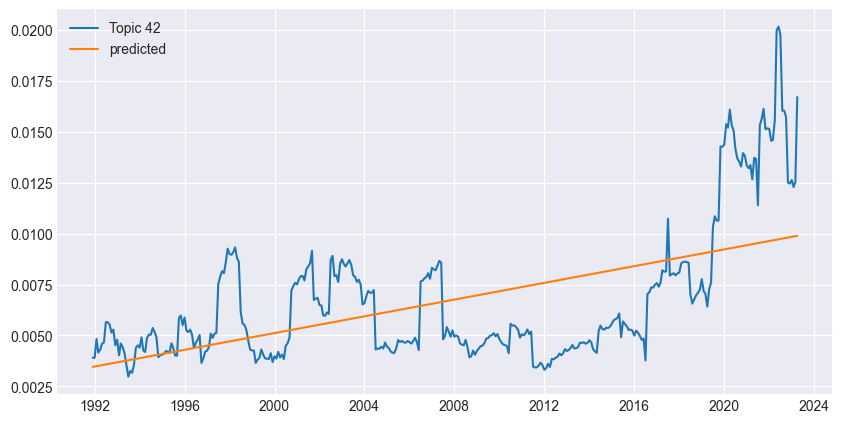

In [10]:
K = 42

vals = pd.DataFrame(rolling_data[f'Topic {K}'])
time = np.arange(len(vals)).reshape(-1, 1)
time = sm.add_constant(time)
results = sm.OLS(vals, time).fit()
vals['predicted'] = results.predict(time)

plt.plot(vals)
plt.legend(vals)
plt.show()

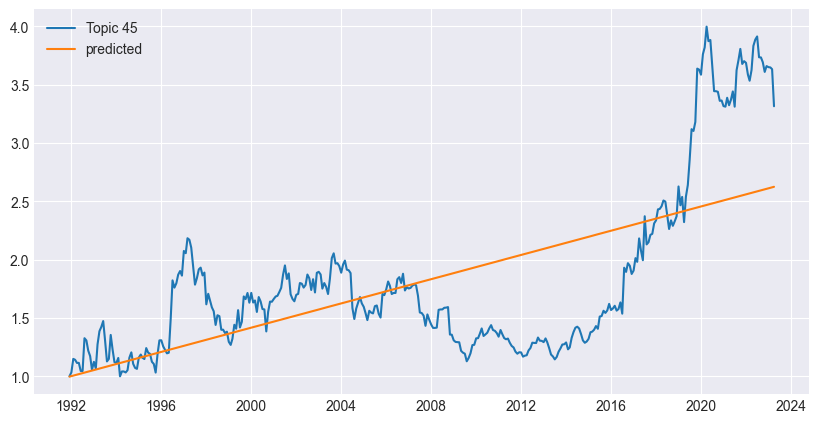

In [51]:
K = 45

vals = pd.DataFrame(rolling_data_norm[f'Topic {K}'])
time = np.arange(len(vals)).reshape(-1, 1)
time = sm.add_constant(time)
results = sm.OLS(vals, time).fit()
vals['predicted'] = results.predict(time)

plt.plot(vals)
plt.legend(vals)
plt.show()

In [12]:
coefs = []

for K in range(60):
    vals = pd.DataFrame(data[f'Topic {K}'])
    time = np.arange(len(vals)).reshape(-1, 1)
    time = sm.add_constant(time)
    results = sm.OLS(vals, time).fit()
    coefs.append((K, results.params[1], results.pvalues[1]))

largest = sorted(coefs, key=lambda x: x[1], reverse=True)[:3]
largest = list(map(lambda x: x[0], largest))
print('largest: ', largest)
smallest = sorted(coefs, key=lambda x: x[1])[:3]
smallest = list(map(lambda x: x[0], smallest))
print('smallest: ', smallest)

largest:  [3, 46, 5]
smallest:  [27, 17, 30]


In [13]:
largest = list(map(lambda x: int(x[-2:]), rolling_data_norm.T.sort_values(by='2023-04-01', ascending=False).head(3).index))
print('largest: ', largest)
smallest = list(map(lambda x: int(x[-2:]), rolling_data_norm.T.sort_values(by='2023-04-01', ascending=True).head(3).index))
print('smallest: ', smallest)

largest:  [3, 46, 35]
smallest:  [11, 17, 30]


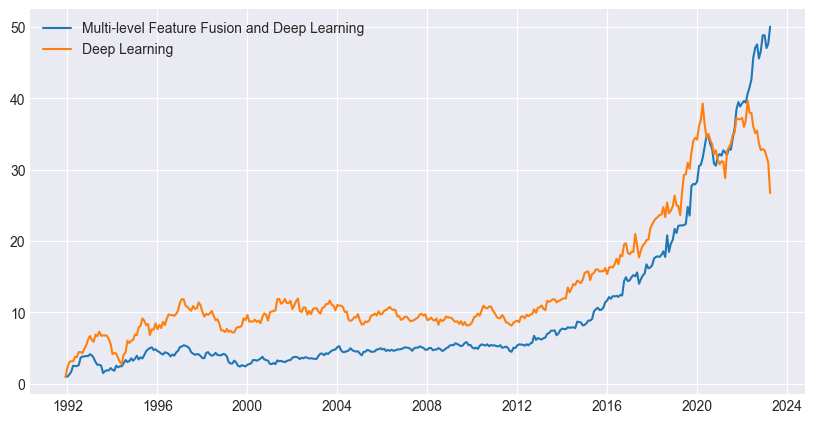

In [48]:
plot = largest[:2]
series = rolling_data_norm[[f'Topic {i}' for i in plot]]

plt.plot(series)
plt.legend(topic_df.iloc[plot]['Labels'])
plt.show()

In [16]:
topic_names = pd.read_csv('models/topics.csv')['Labels']


for K in range(60):
    series = rolling_data_norm[[f'Topic {K}']]
    plt.plot(series, label=topic_names.loc[K], scaley=False)
    plt.legend()
    plt.savefig(f'plots/topic_trends/{topic_names.loc[K]}.png')
    plt.clf()

<Figure size 1000x500 with 0 Axes>

# Topic Entropy Over Time

In [17]:
venues['LDA Distribution'] = df['LDA Distribution']
venues['entropy'] = [entropy([i[1] for i in x]) for x in venues['LDA Distribution']]
entropy_df = (venues.groupby('Date')['entropy'].sum()/venues.groupby('Date')['entropy'].count()).rolling(30).mean().dropna()

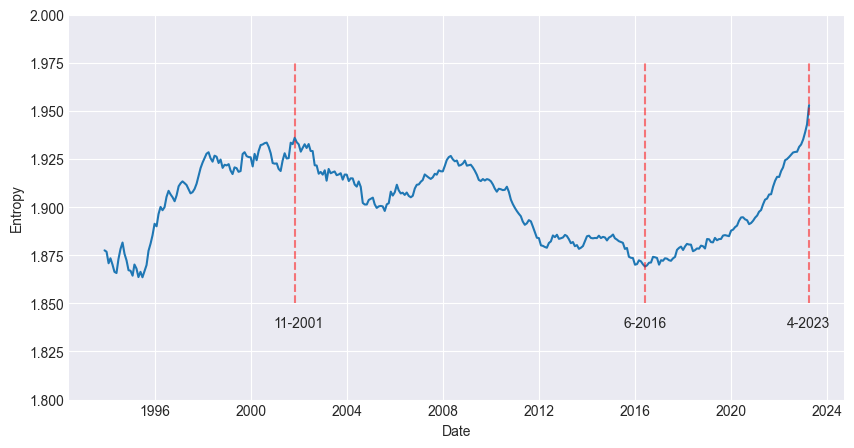

In [46]:

entropy_df = (venues.groupby('Date')['entropy'].sum()/venues.groupby('Date')['entropy'].count()).rolling(36).mean().dropna()
plt.plot(entropy_df)
plt.ylim(1.8, 2)

model = "rbf"
algo = rpt.Pelt(model=model).fit(entropy_df.values)
result = algo.predict(pen=15)

for i in range(1, len(result)):
    segment = entropy_df.iloc[result[i-1]:result[i]]
    if segment.mean() > segment.iloc[0]:
        plt.vlines(segment.idxmax(), 1.85, 1.975, color='red', linestyles='dashed', alpha=0.5)
        plt.annotate(f'{segment.idxmax().month}-{segment.idxmax().year}', (segment.idxmax()-timedelta(days=11*30), 1.8375))
    elif segment.mean() < segment.iloc[0]:
        plt.vlines(segment.idxmin(), 1.85, 1.975, color='red', linestyles='dashed', alpha=0.5)
        plt.annotate(f'{segment.idxmin().month}-{segment.idxmin().year}', (segment.idxmin()-timedelta(days=11*30), 1.8375))

plt.xlabel('Date')
plt.ylabel('Entropy')
plt.show()

In [34]:
data.iloc[np.where(data.index < '2001-10-01')].mean(axis=0).sort_values(ascending=False).head(10)

Topic 27    0.105494
Topic 17    0.056722
Topic 26    0.040804
Topic 30    0.038770
Topic 1     0.036273
Topic 54    0.036256
Topic 4     0.035277
Topic 51    0.032908
Topic 11    0.030239
Topic 22    0.029634
dtype: float64

In [33]:
data.iloc[np.where((data.index > '2001-10-01') & (data.index < '2016-07-01'))].mean(axis=0).sort_values(ascending=False).head(10)


Topic 1     0.051803
Topic 27    0.044082
Topic 59    0.041269
Topic 36    0.038803
Topic 51    0.037026
Topic 17    0.035428
Topic 4     0.032656
Topic 2     0.029310
Topic 54    0.028467
Topic 21    0.027344
dtype: float64

In [35]:
data.iloc[np.where(data.index > '2016-07-01')].mean(axis=0).sort_values(ascending=False).head(10)

Topic 1     0.049701
Topic 3     0.043409
Topic 46    0.042728
Topic 59    0.037932
Topic 51    0.034262
Topic 4     0.032896
Topic 21    0.032011
Topic 5     0.031659
Topic 36    0.028712
Topic 26    0.028104
dtype: float64

In [42]:
data.mean(axis=0).sort_values(ascending=False).head(10)

Topic 27    0.059206
Topic 1     0.046346
Topic 17    0.038307
Topic 59    0.036706
Topic 51    0.035064
Topic 4     0.033495
Topic 26    0.031410
Topic 54    0.030231
Topic 36    0.030020
Topic 21    0.028052
dtype: float64

In [134]:
top_entropy_venues = venues[['Date', 'Venue', 'entropy']].groupby('Venue').mean().sort_values(by='entropy', ascending=False).head(3)
top_entropy_venues

,entropy
Venue,
IEEE-TPAMI,2.000494
ICCV,1.989416
IEEE-CVPR,1.982580


In [136]:
bottom_entropy_venues = venues[['Date', 'Venue', 'entropy']].groupby('Venue').mean().sort_values(by='entropy', ascending=False).tail(3)
bottom_entropy_venues

,entropy
Venue,
IEEE-TNNLS,1.825559
AISTATS,1.801023
IEEE-TFS,1.671213


# Topic Groups

In [200]:
groups = topic_df.groupby('Groups').count().sort_values(by='Labels', ascending=False).head(3).index

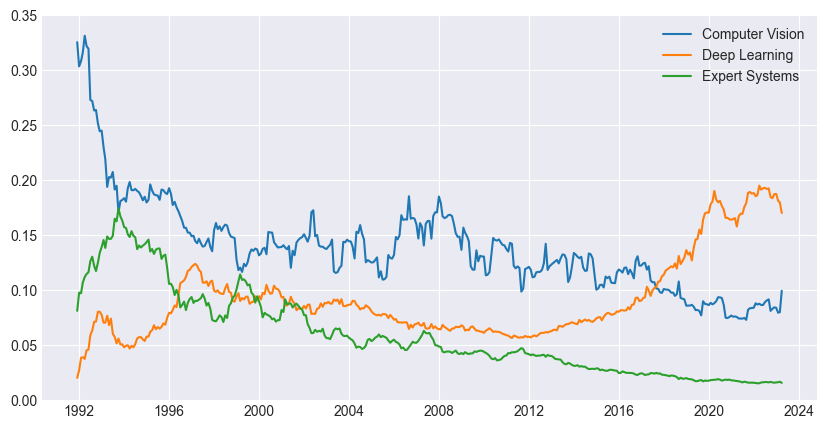

In [65]:
groups = ['CV', 'DL', 'ES']
for g in groups:
    series = rolling_data[[f'Topic {t}' for t in topic_df[topic_df['Groups'] == g]['Topics'].values]]
    series['mean'] = series.sum(axis=1)
    series_norm = series/series.iloc[0]
    plt.plot(series['mean'])

plt.legend(['Computer Vision', 'Deep Learning', 'Expert Systems'])
plt.ylim(0, 0.35)
plt.show()